# The Cart Pole Environment
Let's take what we've learned and try it out on the [Cart Pole environment](https://gym.openai.com/envs/CartPole-v1/).

In [51]:
import numpy as np
import gym

In [52]:
env = gym.make('CartPole-v1')
observation = env.reset()
env.render()

True

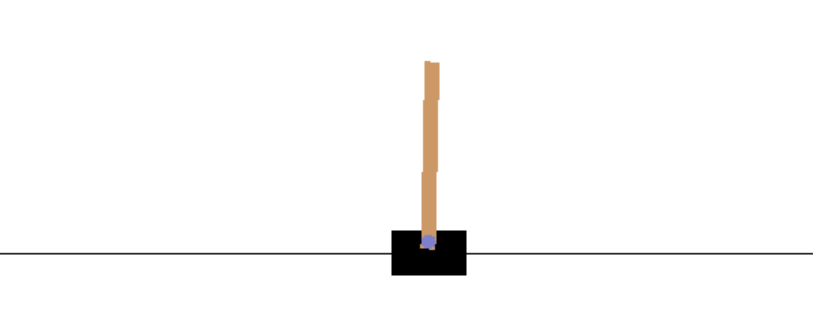

The idea here is there's a cart you can move left or right, and a pole mounted to a joint.  The agent gets rewards each step the pole is above center.  The episode ends if the cart moves too far to the left or right, or if the pole gets more than 15 degrees from vertical.

Let's bring in some of our earlier code and get a random agent going.

In [53]:
env.close()

In [4]:
class Episode:
    """Tracks the history of what happened in a playthrough, which we can use for training."""
    def __init__(self):
        self.steps = [] # For each time step, a tuple of (state, action, reward)
        self.got_reward = False
    
    def record_step(self, state, action, reward):
        step = (state, action, reward)
        self.steps.append(step)
        if reward > -1:
            self.got_reward = True

    def __len__(self):
        return len(self.steps)
            
class RandomPolicy:            
    def __init__(self, env):
        self.env = env

    def suggest_action(self, state):
        return self.env.action_space.sample()
    
    def update_policy(self, episode):
        pass
    
    def generalize(self, observation):
        return observation
            
class Agent:
    max_steps_per_episode = 1000
    
    def __init__(self, env, policy):
        self.env = env
        self.policy = policy
    
    def run_episode(self, render=False):
        episode = Episode()
        observation = env.reset()
        for i in range(self.max_steps_per_episode):
            state = self.policy.generalize(observation)
            action = self.policy.suggest_action(state)
            observation, reward, done, info = env.step(action)
            episode.record_step(state, action, reward)
            if render:
                env.render()
            if done:
                break
        return episode
    
    def train(self, episode_count):
        """Train for a number of episodes.  Returns a list of episode lengths."""
        training_history = []
        for i in range(episode_count):
            episode = self.run_episode()
            self.policy.update_policy(episode)
            training_history.append(len(episode))
        return training_history

rand_agent = Agent(env, RandomPolicy(env))

In [5]:
episode = rand_agent.run_episode(render=True)

Let's look at our state space.  How many attributes are there in the state, and how many in the actions?

In [6]:
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

Box(4,)
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [7]:
print(env.action_space)

Discrete(2)


So there are just 2 actions: move left and move right.

Let's look at that episode to see if we were getting any rewards at first.

In [26]:
episode.steps

[(array([-0.03947672, -0.00646558,  0.02318071, -0.00657104]), 0, 1.0),
 (array([-0.03960603, -0.20191217,  0.02304929,  0.2933346 ]), 0, 1.0),
 (array([-0.04364427, -0.39735504,  0.02891598,  0.59319692]), 1, 1.0),
 (array([-0.05159137, -0.20264954,  0.04077992,  0.30976087]), 1, 1.0),
 (array([-0.05564436, -0.00813162,  0.04697514,  0.03021255]), 0, 1.0),
 (array([-0.055807  , -0.20389465,  0.04757939,  0.33733878]), 0, 1.0),
 (array([-0.05988489, -0.39966024,  0.05432617,  0.64463792]), 1, 1.0),
 (array([-0.06787809, -0.20533579,  0.06721892,  0.3695453 ]), 0, 1.0),
 (array([-0.07198481, -0.4013452 ,  0.07460983,  0.68264292]), 1, 1.0),
 (array([-0.08001171, -0.20733428,  0.08826269,  0.41435111]), 0, 1.0),
 (array([-0.0841584 , -0.40358914,  0.09654971,  0.73350303]), 1, 1.0),
 (array([-0.09223018, -0.20992435,  0.11121977,  0.47270031]), 0, 1.0),
 (array([-0.09642867, -0.40642692,  0.12067378,  0.79826425]), 1, 1.0),
 (array([-0.10455721, -0.21314896,  0.13663906,  0.5458477 ]), 1

The entries in steps are (*state, action, reward*) and we see 1.0's on the right, so yes, we were getting rewards.

I expect that's because the pole is above the line.  Let's let it run a bit more and verify that the rewards go to zero when the pole drops below the line.

In [8]:
len(episode.steps)

12

In [9]:
episode = rand_agent.run_episode(render=True)

In [10]:
len(episode.steps)

32

The first time it did 12 steps, then it did 32 steps.  But it terminated.  Apparently what's going on here is that the episode terminates as soon as the pole drops below a particular angle.

## Generalizing State Space
We've got 4 numbers in our state space, and the state range of those is pretty big.

In [12]:
print(env.observation_space.high)
print(env.observation_space.low)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


We want to break these spaces down into discrete buckets for this exercise. This is so that we take that infinite state space and drop it down to a smaller finite state space so we can track history on similar things and generalize.  Later we'll do that generalization using neural nets, but for now we're going to do something more basic.

### The (overly) simple way
We have 4 parameter features. The first one ranges from 4.8 to -4.8.  We can probably get away with breaking that up into 20 buckets that are equally spaced.  But looking at the example we had, it looks like it has a lot of activity concentrated around the 0.  If we naively cut 4.8 to -4.8 into 20 equally spaced spaces, what would the range look like around 0?

In [17]:
range_start, range_end = -4.8, 4.8
bucket_count = 20
step_size = (range_end - range_start) / bucket_count
step_size

0.48

In [18]:
[range_start + x * step_size for x in range(bucket_count)]

[-4.8,
 -4.32,
 -3.84,
 -3.36,
 -2.88,
 -2.4,
 -1.92,
 -1.44,
 -0.96,
 -0.47999999999999954,
 0.0,
 0.47999999999999954,
 0.96,
 1.4400000000000004,
 1.92,
 2.3999999999999995,
 2.88,
 3.3600000000000003,
 3.8400000000000007,
 4.319999999999999]

If you look above at our episode steps, you can see that all the action for the first parameter of our state observation was all concentrated in a small area around 0:

In [30]:
param0_obs = [step[0][0] for step in episode.steps]

In [32]:
import matplotlib.pyplot as plt

def histogram(seq, bins=10, title='Histogram'):
    plt.hist(seq, edgecolor = 'black', bins = bins)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

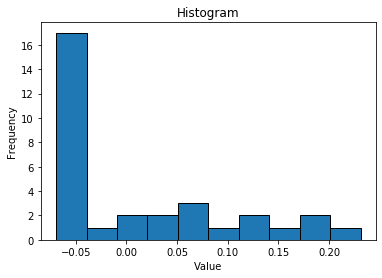

In [33]:
histogram(param0_obs)

So while it's true that the range of this first state value has a possible range from -4.8 to +4.8, it's clear that we need more resolution close to zero, and less resolution out further from zero.  Let's use a sigmoid or a hyperbolic tangent to cram more resolution near zero, and less resolution towards the edges.

## The Beautiful Sigmoid
The *sigmoid* function appears all the time in data science, ai, and statistics, and is defined like this:

$$ f(x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-x} }  $$ 

Let's do these things briefly:
 * Define sigmoid in python
 * Graph it
 * Look at its characteristics
 * Look at why sigmoid is so useful

### Sigmoid in Numpy

In [50]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [57]:
sigmoid(-0.8), sigmoid(0), sigmoid(42)

(0.31002551887238755, 0.5, 1.0)

In [58]:
def plot_fn(f, start, end, point_count = 100):
    x = np.linspace(start, end, point_count)
    y = f(x)
    plt.plot(x, y)
    plt.show()

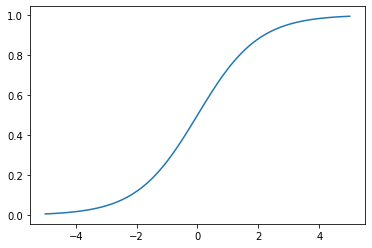

In [59]:
plot_fn(sigmoid, -5, 5)

### Sigmoid's characteristics
* Its output ranges from 0.0 to 1.0
* At zero it is exactly 0.5
* Most of its variation happens near zero

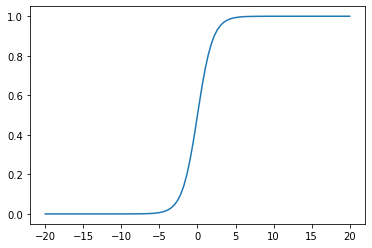

In [61]:
plot_fn(sigmoid, -20, 20)

### Usefulness of Sigmoid
There are many kinds of data where there is a big range of possible values, but in reality most of the variation comes around a single area.  For example, say you're analyzing all your financial transactions.  On average when you spend money the amount spent is under $100 (buying gas, buying food, etc.).  But occasionally you make a car payment or buy a house, and the amount is very large.

If you wanted to do analysis on this data, running the purchase amount through a sigmoid is probably a good idea, because it gives you more resolution around the midpoint, and less resolution out on the ends.
